In [1]:
import glob as gl
import os
import numpy as np
import torch
import matplotlib.pyplot as pl
import matplotlib as mpl
import myutils as mu
import params_feedback as par

In [ ]:
modName = 'FB2'
expName = 'LocMin'
dataName = 'out_accValTa'
baseDirName = '/home/jb739/sheffield/proj/esn_feedback/data/'+modName+'_'+expName
dirNames = gl.glob(baseDirName); dirNames.sort()
# complete = torch.load('/home/jb739/sheffield/proj/esn_feedback/data/'+modName+'_'+expName+'/complete.pt') 
# nLR = complete.shape[0]
data = []; nRuns = []
for j,dirName in enumerate(dirNames): # loop over learning rates
    # runs = complete[j,:]>0 # Boolean vector of which runs completed
    # nRuns.append(np.sum(runs.long().numpy())) # Number of completed runs
    data.append([])
    # if nRuns[j]>0:  # If there are any runs, do:
    fileNames = gl.glob(dirName+'/'+dataName+'*'); fileNames.sort()
    for k, fileName in enumerate(fileNames): # loop over runs (random seeds)
        data[j].append(torch.load(fileName))

modName = 'FB2'
expName = 'swLR'
dataName = 'out_accValTa'
baseDirName = '/home/jb739/sheffield/proj/esn_feedback/data/'+modName+'_'+expName
dirNames = gl.glob(baseDirName+'_*'); dirNames.sort()
complete = torch.load('/home/jb739/sheffield/proj/esn_feedback/data/'+modName+'_'+expName+'_0/complete.pt') 
nLR = complete.shape[0]
datam = []; nRuns = []
j = 4; dirName = dirNames[j]
fileNames = gl.glob(dirName+'/'+dataName+'*'); fileNames.sort()
temp = torch.load(fileNames[0])                
datam.append(np.expand_dims(np.array(torch.load(fileNames[0])), axis=1))
for k in range(1,len(fileNames)): # loop over runs (random seeds)
    datam[0] = np.concatenate((datam[0], np.expand_dims(np.array(torch.load(fileNames[k])), axis=1)), axis=1)

In [ ]:
mu.setupMatplotlib()
kernel = np.ones(50)/50
nEpochs = data[0][0][0].shape[0]
n = len(data[0][0])
fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
for j in range(n):
    pl.plot(np.linspace(1,nEpochs,nEpochs),1. - np.convolve(np.pad(data[0][0][j], (50,50), mode='edge'),kernel,mode='same')[50:-50], linewidth=1.0, color=np.array([j,j,j])/10.)
for j in range(datam[0].shape[1]):
    pl.plot(np.linspace(1,nEpochs,nEpochs),1. - np.convolve(np.pad(datam[0][:,j], (50,50), mode='edge'),kernel,mode='same')[50:-50], linewidth=1.0, color='g')

ax.xaxis.set_ticks((0,nEpochs)); ax.set_yscale('log'); ax.yaxis.set_ticks([0.02,0.05,0.2,0.5]); ax.set_ylim(ymin=0.02, ymax=0.6)
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
pl.savefig('/home/jb739/sheffield/proj/esn_feedback/figs/swLR/acc_multiTransferLearning.svg', format="svg")

In [ ]:
w = torch.load('/home/jb739/sheffield/proj/esn_feedback/data/FB2_LocMin/wTran11113.pt')
mu.setupMatplotlib()
kernel = np.ones(50)/50
nEpochs = data[0][0][0].shape[0]
n = len(data[0][0])
fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
k=[4,7,5,9]
for d,j in enumerate(k):
    pl.plot(np.linspace(1,nEpochs,nEpochs),1. - np.convolve(np.pad(data[0][0][j], (50,50), mode='edge'),kernel,mode='same')[50:-50], linewidth=1.0, color=np.array([j,j,j])/10.)
ax.xaxis.set_ticks((0,nEpochs)); ax.set_yscale('log'); ax.yaxis.set_ticks([0.02,0.05,0.2,0.5]); ax.set_ylim(ymin=0.02, ymax=0.6)
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

fig = pl.figure(figsize=tuple(np.array((25.,15.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
pl.plot(w[5][0][:50,0]);pl.plot(w[9][0][:50,0]);pl.plot(w[0][0][:50,0])
# pl.plot(w[5][1]);pl.plot(w[9][1])

In [9]:
def esn_feedback_ana(key,**kwa):

    ### Load accuracy data
    if key=='loadData':
        # kwa needs: modName, expName, dataName
        baseDirName = '/home/jb739/sheffield/proj/esn_feedback/data/'+kwa['modName']+'_'+kwa['expName']
        dirNames = gl.glob(baseDirName+'_*'); dirNames.sort()
        complete = torch.load('/home/jb739/sheffield/proj/esn_feedback/data/'+kwa['modName']+'_'+kwa['expName']+'_0/complete.pt') 
        nLR = complete.shape[0]
        data = []; nRuns = []
        for j,dirName in enumerate(dirNames): # loop over learning rates
            runs = complete[j,:]>0 # Boolean vector of which runs completed
            nRuns.append(np.sum(runs.long().numpy())) # Number of completed runs
            data.append([]) # Add list element for this learning rate
            if nRuns[j]>0:  # If there are any runs, do:
                fileNames = gl.glob(dirName+'/'+kwa['dataName']+'*'); fileNames.sort()
                for k, fileName in enumerate(fileNames): # loop over runs (random seeds)
                    data[j].append(torch.load(fileNames[k])) # Load file data (for accuracies, this is a list)

        return data
    
    ### Plot accuracies as error (1 - accuracy)
    if key=='plotAcc':
        # kwa needs: acc, saveFlag, figDir, figName
        mu.setupMatplotlib()
        acc = kwa['acc']
        nEpochs = acc[0].shape[0]
        n = len(acc)
        col1 = np.array(tuple(x**2 for x in (0.,1.,0.3))); col2 = np.array(tuple(x**2 for x in (0.8, 0., 1.)))
        colShade = np.linspace(0.,1.,n)
        kernel = np.ones(50)/50
        fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
        ax.spines[['top','right']].set_visible(False)
        for j in range(n):
            col = tuple(np.sqrt(colShade[j]**2 * col2 + colShade[n-1-j]**2 * col1))
            if np.size(acc[j])>0:
                pl.plot(np.linspace(1,nEpochs,nEpochs),1. - np.convolve(np.pad(np.mean(acc[j],1), (50,50), mode='edge'),kernel,mode='same')[50:-50], linewidth=1.0, color=col)
        ax.xaxis.set_ticks((0,nEpochs)); ax.set_yscale('log'); ax.yaxis.set_ticks([0.02,0.05,0.2,0.5]); ax.set_ylim(ymin=0.02, ymax=0.6)
        ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
        if kwa['saveFlag']:
            mu.checkMakeDir(kwa['figDir'])
            pl.savefig(kwa['figDir']+'/'+kwa['figName']+'.svg', format="svg")
    
    ### Load saved responses
    if key=='loadResp':
        # Return list of responses. Eac list element is for a different seed. Responses are from one layer
        # kwa needs: modName, expName, dataName, selectLR, maxNSeeds, layer
        baseDirName = '/home/jb739/sheffield/proj/esn_feedback/data/'+kwa['modName']+'_'+kwa['expName']+'_*'
        dataDirNames = gl.glob(baseDirName); dataDirNames.sort()
        data = []
        for j,d in enumerate(dataDirNames): # For each learning rate
            if j!=kwa['selectLR']: # For selected best learning rate
                continue
            baseFileName = d+'/'+kwa['dataName']+'*'
            fNames = gl.glob(baseFileName); fNames.sort()
            for f, fName in enumerate(fNames): # For each seed
                if f==kwa['maxNSeeds']: # Only process maxNSeeds seeds
                    break
                # Load response data from fName (1 layer only)
                print(fName)
                r = torch.load(fName)[kwa['layer']] 
                # Create new list element for r-data, with shape [#iterations saved, #samples, #neurons x #time steps]
                # data.append(np.reshape(r, (r.shape[0], r.shape[1], r.shape[2]*r.shape[3]))) 
                data.append(r) 

        return data
    
    ### Compute principle components
    if key=='computePCA':
        # kwa needs: data
        from sklearn.decomposition import PCA
        from sklearn.manifold import TSNE
        from scipy import stats
        # Preprocess data
        if len(kwa['data'].shape)>3:
            data = kwa['data'][-1,:,:,:]
        else:
            data = kwa['data']
        # for j in range(data.shape[0]):
        #     data[j,:,:] = stats.zscore(data[j,:,:])
        # Init PCA object
        pca = PCA(n_components=np.minimum(data.shape[0],data.shape[1]))
        # Perform PCA and return transformed data (last saved time point)
        # p = pca.fit_transform(np.mean(data[-2,:,:]))
        print(np.sum(np.double(np.isnan(data))))
        p = pca.fit_transform(np.mean(data[:,:,-5:], axis=2))

        return p, pca
    
    ### Plot class trajectories and clusters in PCA space
    if key=='plotPCA':
        # kwa needs: data, pca, pc, saveTime, saveFlag, figDir, figSuffix
        ### Process inputs
        data = kwa['data'] # Responses
        pca = kwa['pca'] # PCA function
        pc = kwa['pc'] # 1st 2 PCs that define PC space
        var = np.cumsum(np.array(list(x*100 for x in pca.explained_variance_ratio_)))
        if len(kwa['data'].shape)>3:
            nt = data.shape[3] # No. time steps
            nn = data.shape[2] # No. neurons
            ns = data.shape[1] # No. samples
        else:
            nt = data.shape[2]
            nn = data.shape[1]
            ns = data.shape[0]
        nspc = int(ns/10)  # No. samples per cluster
        mapData = np.zeros((ns, 2, nt))
        if len(kwa['data'].shape)>3:
            for t in range(nt):
                mapData[:,:,t] = pca.transform(data[kwa['saveTime'],:,:,t])[:,0:2]
        else:
            for t in range(nt):
                mapData[:,:,t] = pca.transform(data[:,:,t])[:,0:2]
        
        ### Generate figures
        mu.setupMatplotlib()
        # Plot variance explained
        fig = pl.figure(figsize=tuple(np.array((2.,4.))/2.54)); ax = pl.axes()
        ax.spines[['top','right']].set_visible(False)
        pl.scatter(np.linspace(1,ns,var.shape[0]), var, s=3, color='k', alpha=0.5, linewidths=0)
        pl.plot(np.linspace(1,ns,2), np.ones(2)*90, '--', color=(0.5, 0.5, 0.5), linewidth=0.5)
        ax.set_xscale('log')
        # pl.xticks([1,10,100], ['1','10','100'], minor=[2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90])
        ax.xaxis.set_ticks((1, 20, 200)); ax.yaxis.set_ticks((0,100))
        ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
        ax.set_xlim(xmin=0.5, xmax=200); ax.set_ylim(ymin=0, ymax=100)
        if kwa['saveFlag']:
            mu.checkMakeDir(kwa['figDir'])
            pl.savefig(kwa['figDir']+'varExplained_'+kwa['figSuffix']+'.svg', format="svg")
        # Plot PCA clusters
        fig = pl.figure(figsize=tuple(np.array((4.,4.))/2.54)); ax = pl.axes()
        ax.spines[['top','right']].set_visible(False)
        for j in range(10):
            col = mpl.colormaps['tab10'].colors[j]
            pl.scatter(pc[j*nspc:(j+1)*nspc,0], pc[j*nspc:(j+1)*nspc,1], s=3, color=col)
        ax.xaxis.set_ticks((-10,0,10)); ax.yaxis.set_ticks((-10,0,10))
        ax.set_xlim(xmin=-16, xmax=16); ax.set_ylim(ymin=-16, ymax=16)
        if kwa['saveFlag']:
            mu.checkMakeDir(kwa['figDir'])
            pl.savefig(kwa['figDir']+'pcaClusters_'+kwa['figSuffix']+'.svg', format="svg")
        ### Plot mean class response trajectory in PC space
        fig = pl.figure(figsize=tuple(np.array((4.,4.))/2.54)); ax = pl.axes()
        ax.spines[['top','right']].set_visible(False)
        scale = np.logspace(-1,0,nt)
        for j in range(10):
            col = mpl.colormaps['tab10'].colors[j]
            for t in range(mapData.shape[2]-1):
                colT = tuple(x**scale[t] for x in col)
                pl.plot(np.mean(mapData[j*nspc:(j+1)*nspc,0,t:t+2], axis=0), np.mean(mapData[j*nspc:(j+1)*nspc,1,t:t+2], axis=0), color=colT, linewidth=1)
        ax.xaxis.set_ticks((-10,0,10)); ax.yaxis.set_ticks((-10,0,10))
        ax.set_xlim(xmin=-16, xmax=16); ax.set_ylim(ymin=-16, ymax=16)
        if kwa['saveFlag']:
            mu.checkMakeDir(kwa['figDir'])
            pl.savefig(kwa['figDir']+'pcaTraj_'+kwa['figSuffix']+'.svg', format="svg")
    
    ### Compute clustering index
    if key=='clusterIndex':
        # kwa needs: data
        ### Compute Silhuoette Index
        if len(kwa['data'].shape)>3:
            r = np.mean(kwa['data'][-1,:,:,-5:], axis=2)
        else:
            r = np.mean(kwa['data'][:,:,-5:], axis=2)
        ns = r.shape[0] # No. samples
        nc = 10 # No. clusters
        nspc = int(ns/nc)  # No. samples per cluster
        dist = np.zeros((ns, ns))
        # Compute distances between samples
        for j in range(ns):
            dist[:,j] = np.sqrt(np.sum((r - np.roll(r, -j, axis=0))**2, axis=1))
        # Rearrange dist to yield distance matrix
        # Fill diagonal of dist matrix with NaNs
        for j in range(ns):
            dist[j,:] = np.roll(np.expand_dims(dist[j,:], axis=0), j, axis=1)
            dist[j,j] = np.NaN
        # Compute mean distance from each sample to each cluster
        mDist = np.zeros((ns, nc))
        for j in range(nc):
            mDist[:,j] = np.nanmean(dist[:,j*nspc:(j+1)*nspc], axis=1)
        # Rearrange mDist so that each sample's own cluster is in first column
        for j in range(nc):
            mDist[j*nspc:(j+1)*nspc,:] = np.roll(mDist[j*nspc:(j+1)*nspc,:], -j, axis=1)
        # Calculate Silhuoette Index
        a = np.expand_dims(mDist[:,0], axis=1); b = np.expand_dims(np.min(mDist[:,1:], axis=1), axis=1)
        SI = np.divide(b - a, np.expand_dims(np.max(np.concatenate((a,b), axis=1), axis=1), axis=1))

        return SI
    
    ### Plot cluster indeces
    if key=='plotClusterIndex':
        # kwa needs: ci, figDir, figSuffix, saveFlag
        ci = kwa['ci']
        nc = 10 # No. classes
        ns = ci.shape[0] # No. samples
        nspc = int(ns/nc) # No. samples per cluster
        mu.setupMatplotlib()
        fig = pl.figure(figsize=tuple(np.array((4.,4.))/2.54)); ax = pl.axes()
        ax.spines[['top','right']].set_visible(False)
        for j in range(10):
            col = mpl.colormaps['tab10'].colors[j]
            # pl.plot(np.linspace(j*10+1,(j+1)*10,10), ci[j*10:(j+1)*10], linewidth=1, color=col)
            pl.scatter(np.linspace(j*nspc+1,(j+1)*nspc,nspc), ci[j*nspc:(j+1)*nspc], s=3, color=col)
        pl.plot(np.linspace(0,ns+1,2), np.ones(2)*np.mean(ci), '--', color=(0.5, 0.5, 0.5), linewidth=0.5)
        ax.xaxis.set_ticks((1,200)); ax.yaxis.set_ticks((-1,0,1))
        ax.set_xlim(xmin=0, xmax=201); ax.set_ylim(ymin=-1, ymax=1)
        if kwa['saveFlag']:
            mu.checkMakeDir(kwa['figDir'])
            pl.savefig(kwa['figDir']+'clusterIndex_'+kwa['figSuffix']+'.svg', format="svg")

    ### Plot mean cluster indeces across runs for all models
    if key=='allSI':
        # kwa needs: prefix, lr_index, layer
        # Load data and compute silhouette indeces

        baseName = '/home/jb739/sheffield/proj/esn_feedback/data/'
        models = ('0', '1', '2')
        experiment = 'swLR'
        si = np.zeros((len(models), 5))
        for j, model in enumerate(models):
            dirNames = gl.glob(baseName+kwa['prefix']+model+'_'+experiment+'_*'); dirNames.sort(); 
            print(dirNames)
            dirName = dirNames[kwa['lr_index']] 
            print(dirName)
            dataName = 'respSave'
            r = esn_feedback_ana('loadResp',modName=kwa['prefix']+model,expName=experiment,dataName=dataName,selectLR=kwa['lr_index'],maxNSeeds=5,layer=kwa['layer'])
            for k in range(len(r)):
                si[j,k] = np.mean(esn_feedback_ana('clusterIndex',data=r[k]))

        return si
        
    ### Plot all mean SIs
    if key=='plotAllSI':
        # kwa needs: si, figDir, layer, prefix
        si = kwa['si']
        mSI = np.mean(si,axis=1)
        sSI = np.std(si, axis=1)
        col1 = (0.5,0,0,0.33) if kwa['layer']==2 else (0,0,0,0.33)
        col2 = (0.5,0,0,1) if kwa['layer']==2 else (0,0,0,1)
        mu.setupMatplotlib()
        fig = pl.figure(figsize=tuple(np.array((4.,4.))/2.54)); ax = pl.axes()
        ax.spines[['top','right']].set_visible(False)
        for j in range(si.shape[0]):
            pl.scatter(j+np.random.uniform(-0.25,0.25,(si.shape[1],1)), si[j,:], c=col1, s=3, edgecolors='none')
        pl.errorbar(list(range(3)), mSI, yerr=sSI, fmt='o', color=col2, markersize=3, markeredgecolor='none')
        ax.xaxis.set_ticks(list(range(3))); ax.yaxis.set_ticks([0.1,0.4,0.7])
        ax.set_xlim(xmin=-0.5, xmax=2.5); ax.set_ylim(ymin=0.1, ymax=0.7)
        if kwa['saveFlag']:
            mu.checkMakeDir(kwa['figDir'])
            pl.savefig(kwa['figDir']+'/allSI'+kwa['prefix']+'_L'+str(kwa['layer'])+'_'+'.svg', format="svg")

    ### Plot histograms of DW (weight changes)
    if key=='plotDW':
        # kwa needs: modName, expName, dataName, figDir, layer (count from 0, do not use -ve index), time (saved time point)
        baseDirName = '/home/jb739/sheffield/proj/esn_feedback/data/'+kwa['modName']+'_'+kwa['expName']; print(baseDirName)
        dirNames = gl.glob(baseDirName+'_*'); dirNames.sort(); 
        complete = torch.load('/home/jb739/sheffield/proj/esn_feedback/data/'+kwa['modName']+'_'+kwa['expName']+'_0/complete.pt') 
        nLR = complete.shape[0]
        dwEdges = torch.logspace(-10,-3,51) # Edges used to build histogram
        histogram = [] # init histograms
        fWeights = []  # init count for number of changing weights
        dwMode = [] # Init modal DW as a function of time
        for j, dirName in enumerate(dirNames): # Loop over learning rates
            runs = complete[j,:]>0         # Boolean vector of which runs completed
            nRuns= np.sum(runs.long().numpy())      # Number of completed runs
            if nRuns>0:  # If there are any runs, do:    
                histogram.append(np.zeros((50))) # Init storage for dw histograms
                dwMode.append(np.ones((25))) # Init storage for dwMode
                fileNames = gl.glob(dirName+'/dw*'); fileNames.sort() # Get run filenames
                for k, fileName in enumerate(fileNames): # for all other completed runs
                    if complete[j,k]>0:
                        h = torch.load(fileName)[kwa['layer']]
                        histogram[j] += h[:,kwa['time']]
                        dwMode[j] = np.multiply(dwMode[j],dwEdges[np.argmax(h, axis=0)])
                histogram[j] /= nRuns # Normalise by number of successful runs
                dwMode[j] = np.power(dwMode[j], float(1/nRuns)) # Geometric mean of learning rates
                fWeights.append(histogram[j].sum()/(par.Ns[kwa['layer']]*par.Ns[kwa['layer']+1])) # Fraction of weights that change
            else:
                # if no completed runs, append empty arrays
                histogram.append([])
                fWeights.append([])
                dwMode.append([])
        
        # Plot DW histograms
        mu.setupMatplotlib()
        fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
        ax.spines[['top','right']].set_visible(False)
        col1 = np.array(tuple(x**2 for x in (0.,1.,0.3))); col2 = np.array(tuple(x**2 for x in (0.8, 0., 1.)))
        colShade = np.linspace(0.,1.,nLR)
        for j, hist in enumerate(histogram):
            if len(hist)>0 and fWeights[j]>0.25: # if there is a histogram (i.e. at least one successful run)
                col = tuple(np.sqrt(colShade[j]**2 * col2 + colShade[nLR-1-j]**2 * col1)) # set colour for this learning rate
                pl.plot(dwEdges[:50],hist / hist.sum(), linewidth=1.0, color=col) # plot histogram
                print(hist.sum())
            else:
                print([])
        ax.set_ylim(ymin=0, ymax=0.2)
        pl.xscale('log')
        if kwa['saveFlag']:
            mu.checkMakeDir(kwa['figDir'])
            pl.savefig(kwa['figDir']+'/dwHistogram_'+kwa['modName']+'.svg', format="svg")
        
        # Plot number of changing weights
        fig = pl.figure(figsize=tuple(np.array((2.,1.))/2.54)); ax = pl.axes()
        ax.spines[['top','right']].set_visible(False)
        for j, frac in enumerate(fWeights):
            if fWeights[j]>0.25:
                col = tuple(np.sqrt(colShade[j]**2 * col2 + colShade[nLR-1-j]**2 * col1)) # set colour for this learning rate
                pl.scatter(j, frac, s=3, color=col)
        ax.xaxis.set_ticks([]); ax.yaxis.set_ticks((0,1))
        if kwa['saveFlag']:
            mu.checkMakeDir(kwa['figDir'])
            pl.savefig(kwa['figDir']+'/dwCount_inset_'+kwa['modName']+'.svg', format="svg")

        # Plot evolution of modal DW
        fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
        ax.spines[['top','right']].set_visible(False)
        for j, mode in enumerate(dwMode):
            if len(mode)>0:
                col = tuple(np.sqrt(colShade[j]**2 * col2 + colShade[nLR-1-j]**2 * col1)) # set colour for this learning rate
                pl.plot(np.linspace(0,par.nEpochs,25), mode, linewidth=1.0, color=col)
        pl.yscale('log'); ax.yaxis.set_ticks([1e-7,1e-5,1e-3]); ax.yaxis.set_ticklabels(['$10^{-7}$','$10^{-5}$','$10^{-3}$']); ax.xaxis.set_ticks([0,5000]); ax.set_ylim(ymin=1e-7, ymax=dwEdges[-1])
        # ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
        if kwa['saveFlag']:
            mu.checkMakeDir(kwa['figDir'])
            pl.savefig(kwa['figDir']+'/dwModeEvo_'+kwa['modName']+'.svg', format="svg")
      

# Select and run analyses


### Plot training phase 1 accuracies

In [15]:
model = 'out2FB2'
experiment = 'swLR'
key = 'loadData'; dataName = 'accValTa'
acc = esn_feedback_ana(key,modName=model,expName=experiment,dataName=dataName)
key = 'plotAcc'; saveFlag = True; 
esn_feedback_ana(key,acc=acc,saveFlag=saveFlag, figDir='./figs/swLR/', figName=dataName+'_'+model)

# To estimate which LR to use for further analyses
mx = 0; mxind = 0
for i in range(len(acc)):
    if np.size(acc[i])>0:
        mn = np.mean(np.mean(acc[i][-100:,:], axis=0))
        print(f'{i}: {mn}')
        if mn>mx:
            mx = mn; mxind = i
    else:
        print('None')
print(f'Max is LR-index {mxind}')

AttributeError: 'list' object has no attribute 'shape'

### Plot transfer learning accuracies


In [21]:
modName = 'out2proFB2'
expName = 'swLR'
dataName = 'out_accValTa'
seed='11113'
baseDirName = '/home/jb739/sheffield/proj/esn_feedback/data/'+modName+'_'+expName
print(baseDirName)
print(baseDirName+'/'+dataName+'_'+seed+'.pt')
a = torch.load(baseDirName+'/'+dataName+'_'+seed+'.pt')

/home/jb739/sheffield/proj/esn_feedback/data/out2proFB2_swLR
/home/jb739/sheffield/proj/esn_feedback/data/out2proFB2_swLR/out_accValTa_11113.pt


FileNotFoundError: [Errno 2] No such file or directory: '/home/jb739/sheffield/proj/esn_feedback/data/out2proFB2_swLR/out_accValTa_11113.pt'

0: 0.5016799862384796
1: 0.4603999866843223
2: 0.5523599879741669
3: 0.6445599851608277
4: 0.7021199811697005
Max is LR-index 4


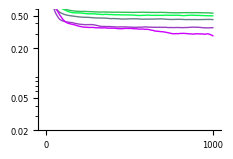

In [14]:
model = 'out2FB0'
experiment = 'swLR'
key = 'loadData'; dataName = 'out_accValTa'
# load accuracies (nested lists, acc[#learning rates][#runs per LR][# transfer learning instances])
acc = esn_feedback_ana(key,modName=model,expName=experiment,dataName=dataName)
accpl = []
for j in range(len(acc)):
    accpl.append([])
    accpl[j] = np.zeros((acc[j][0][0].shape[0],len(acc[j])))
    for k in range(len(acc[j])):
        accpl[j][:,k] = acc[j][k][0]
key = 'plotAcc'; saveFlag = False; 
esn_feedback_ana(key,acc=accpl,saveFlag=saveFlag, figDir='./figs/swLR/', figName=dataName+'_'+model)

# To estimate which LR to use for further analyses
mx = 0; mxind = 0
for i in range(len(accpl)):
    if np.size(accpl[i])>0:
        mn = np.mean(np.mean(accpl[i][-100:,:], axis=0))
        print(f'{i}: {mn}')
        if mn>mx:
            mx = mn; mxind = i
    else:
        print('None')
print(f'Max is LR-index {mxind}')

### Perform PCA and clustering analyses on final hidden layer responses

In [ ]:
r[0].shape
fig = pl.figure(figsize=tuple(np.array((8.,8.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
pl.plot(r[0][0,21,:,:].transpose())
pl.show()

In [ ]:
### Plot response examples
saveFlag=True; LR_index = 4; model = 'proFB2'; layer=2
# Load data
experiment = 'swLR'; key = 'loadResp'; dataName = 'respSave11113'
r = esn_feedback_ana(key,modName=model,expName=experiment,dataName=dataName,selectLR=LR_index,maxNSeeds=1,layer=layer)
# Compute principle components
key = 'computePCA'
p, *pca = esn_feedback_ana(key,data=r[0])
# Plot PCs
key = 'plotPCA'; figSuffix=model+'_LR'+str(LR_index)+'_'+'layer'+str(layer)+'_'+dataName[-5:]
esn_feedback_ana(key,data=r[0], pca=pca[0], pc=p, saveTime=-1, saveFlag=saveFlag, figDir='./figs/swLR/', figSuffix=figSuffix)
# Compute Clustering Index
key = 'clusterIndex'
SI = esn_feedback_ana(key,data=r[0])
# Plot cluster indeces
key = 'plotClusterIndex'; figDir = './figs/swLR/'
esn_feedback_ana(key, ci=SI, figDir=figDir, figSuffix=figSuffix, saveFlag=saveFlag)
# Plot mean SI across runs for all models
key = 'plotMeanSI'; 
esn_feedback_ana(key)

In [ ]:
### Plot results summary for all models
key = 'allSI'; layer = 1; prefix='proFB'
si = esn_feedback_ana(key, prefix=prefix, lr_index=4, layer=layer)
key = 'plotAllSI'; figDir='./figs/swLR'
esn_feedback_ana(key, si=si, figDir=figDir, layer=layer, prefix=prefix, saveFlag=True)
print(si)


### Plot feedback weight evolution

In [ ]:
weights=torch.load('/home/jb739/sheffield/proj/esn_feedback/data/metFB3_swLR_4/weightSave11117.pt')
fig = pl.figure(figsize=tuple(np.array((20.,5.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
for j in range(0,1000,100):
    pl.plot(np.linspace(1,5000,26),weights[::2,j,:].transpose(), linewidth=0.5)
ax.xaxis.set_ticks((0,5000)); ax.yaxis.set_ticks((-.05,0,.05)); ax.set_ylim(-.5,.5)
print(weights[0,0,:])

### Plot evolution of mean weight changes

In [ ]:
saveFlag = True
key = 'plotDW'; model = 'FB2'; experiment = 'swLR'
esn_feedback_ana(key, saveFlag=saveFlag, modName=model, expName=experiment, figDir='./figs/swLR/', layer=1, time=-1)